Ensure the images are present in the 'training' folder. Run the label images cells below to populate the 'labeled' folder. 

## Label Images

In [ ]:
import cv2
import pandas as pd
import os
import numpy as np
from PIL import Image

# Load the CSV file
csv_file_path = '../data/mockupdetection_724.csv'
data = pd.read_csv(csv_file_path)

# Directory to save binary masks
output_dir = '../images/masks'
os.makedirs(output_dir, exist_ok=True)

# Function to create binary mask from image and bounding box
def create_binary_mask(image_path, top, left, height, width):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if image is None:
        print(f"Failed to load image at path: {image_path}")
        return None
    
    # Create an empty mask with the same dimensions as the image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # Fill the bounding box area with white color
    mask[top:top+height, left:left+width] = 255
    
    return mask

# Process each row in the CSV file
for index, row in data.iterrows():
    image_path = row['image_path']
    top, left, height, width = int(row['top']), int(row['left']), int(row['height']), int(row['width'])
    
    # Create binary mask
    binary_mask = create_binary_mask(image_path, top, left, height, width)
    
    if binary_mask is not None:
        # Construct the output mask path
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        output_mask_path = os.path.join(output_dir, f"{base_name}.png")
        
        # Save the binary mask
        cv2.imwrite(output_mask_path, binary_mask)
        print(f"Saved mask to {output_mask_path}")

print("Binary masks have been created and saved.")


## Data Preparation 

In [15]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FrameDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

image_dir = '/Users/matt/documents/coding/midjourney/mockcrop/images/training'
mask_dir = '/Users/matt/documents/coding/midjourney/mockcrop/images/masks'
dataset = FrameDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


## Model Creation

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

class FrameSegmentationModel(nn.Module):
    def __init__(self, num_classes=1):
        super(FrameSegmentationModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer
        self.upsample = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1),
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)  # Ensure the output size matches the input size
        )

    def forward(self, x):
        x = self.resnet(x)
        x = x.unsqueeze(-1).unsqueeze(-1)  # Add dimensions to match the upsample input
        x = self.upsample(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FrameSegmentationModel().to(device)

## Training

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Loss and optimizer
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print('Training complete')

# Save the model after training
model_save_path = '../models/unet_model_730_dataaug.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


Epoch [1/10], Loss: 0.7521
Epoch [2/10], Loss: 0.7276
Epoch [3/10], Loss: 0.7046
Epoch [4/10], Loss: 0.6714
Epoch [5/10], Loss: 0.6200
Epoch [6/10], Loss: 0.6660
Epoch [7/10], Loss: 0.6070
Epoch [8/10], Loss: 0.5284
Epoch [9/10], Loss: 0.5121
Epoch [10/10], Loss: 0.4877
Training complete
Model saved to ../models/unet_model_730_dataaug.pth


## Validate

Model loaded from ../models/resnet_model_730_dataaug.pth


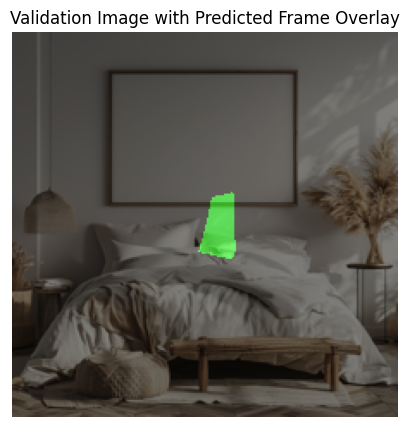

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the model
model_load_path = '../models/resnet_model_730_dataaug.pth'
model = FrameSegmentationModel().to(device)
model.load_state_dict(torch.load(model_load_path))
model.eval()
print(f'Model loaded from {model_load_path}')

# Validation image path
validation_image_path = '../images/validate/bedroom_mockup.png'

# Load and preprocess the validation image
validation_image = Image.open(validation_image_path).convert("RGB")
validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
validation_image_tensor = validation_transform(validation_image).unsqueeze(0).to(device)

# Perform prediction
with torch.no_grad():
    prediction = model(validation_image_tensor)
    prediction = torch.sigmoid(prediction).cpu().numpy()[0, 0]

# Apply a threshold to the prediction to create a binary mask
threshold = 0.5
binary_mask = prediction > threshold

# Create a green overlay where the mask is true
green_overlay = np.zeros((224, 224, 3), dtype=np.uint8)
green_overlay[binary_mask] = [0, 255, 0]

# Convert the green overlay to an image
green_overlay_image = Image.fromarray(green_overlay)

# Resize the original validation image to match the overlay size
validation_image_resized = validation_image.resize((224, 224))

# Blend the original image with the green overlay
blended_image = Image.blend(validation_image_resized, green_overlay_image, alpha=0.5)

# Display the blended image
plt.figure(figsize=(10, 5))
plt.imshow(blended_image)
plt.title('Validation Image with Predicted Frame Overlay')
plt.axis('off')
plt.show()
